In [1]:
# import openai

In [2]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

In [3]:
# openai.api_key = os.environ["OPENAI_API_KEY"]

In [4]:
# %reload_ext genai

In [5]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [6]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [7]:
!ls -l data

total 16656
-rw-r--r-- 1 pete-00 pete-00 17051982 Apr 17 18:35 mnist.pkl.gz


In [8]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [9]:
lst1 = list(x_train[0])

In [10]:
vals = lst1[200:210]

In [11]:
vals, len(lst1)

([0.0,
  0.0,
  0.0,
  0.19140625,
  0.9296875,
  0.98828125,
  0.98828125,
  0.98828125,
  0.98828125,
  0.98828125],
 784)

In [12]:
def chunks(x, sz):
    for i in range(0, len(x), sz):
        yield x[i:i+sz]

In [13]:
val_iter = chunks(vals, 5)

In [14]:
len(next(chunks(lst1, 28)))

28

In [15]:
mpl.rcParams['image.cmap'] = 'gray'

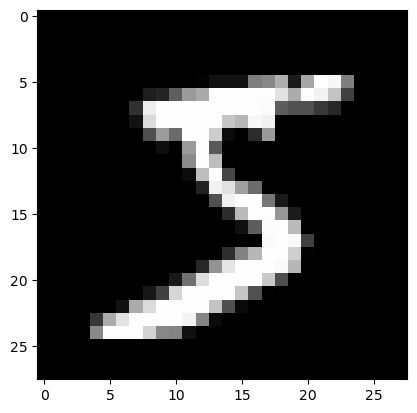

In [16]:
plt.imshow(list(chunks(lst1, 28)))

In [17]:
from itertools import islice

In [18]:
it = iter(lst1)
islice(it, 5)

In [19]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.0, 0.0]

In [20]:
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 28)), []))

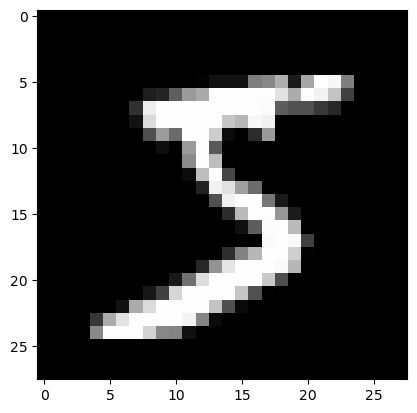

In [21]:
plt.imshow(img)

In [22]:
class Matrix:
    def __init__(self, xs):
        self.xs = xs
    def __getitem__(self, idxs):
        return self.xs[idxs[0]][idxs[1]]

In [23]:
m = Matrix(img)

In [24]:
m[20,15]

0.98828125

In [25]:
import torch
from torch import tensor

In [26]:
tensor([1,2,3])

tensor([1, 2, 3])

In [27]:
tens = tensor(img)

In [28]:
tens[20,15]

tensor(0.9883)

In [29]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [30]:
x_train.shape

torch.Size([50000, 784])

In [31]:
x_train.dtype

torch.float32

In [32]:
imgs = x_train.reshape(-1, 28, 28)
imgs.shape

torch.Size([50000, 28, 28])

In [33]:
imgs[0].shape

torch.Size([28, 28])

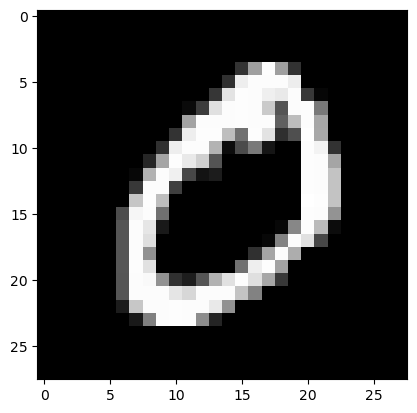

In [34]:
plt.imshow(imgs[1]);

In [35]:
n,c = x_train.shape

In [36]:
n, c

(50000, 784)

In [37]:
x_train.shape

torch.Size([50000, 784])

In [38]:
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

In [39]:
min(y_train), max(y_train)

(tensor(0), tensor(9))

In [40]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))

### Random Number Generators

In [41]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [42]:
seed(457428938475)
rnd_state

(4976, 20238, 499)

In [43]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

In [44]:
rand(), rand(), rand(),

(0.7645251082582081, 0.7920889799553945, 0.06912886811267205)

In [45]:
if os.fork(): print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.9559050644103264
In child: 0.9559050644103264


In [46]:
if os.fork(): print(f'In parent: {torch.rand(1)}')
else:
    print(f'In child: {torch.rand(1)}')
    os._exit(os.EX_OK)

In parent: tensor([0.9501])
In child: tensor([0.9501])


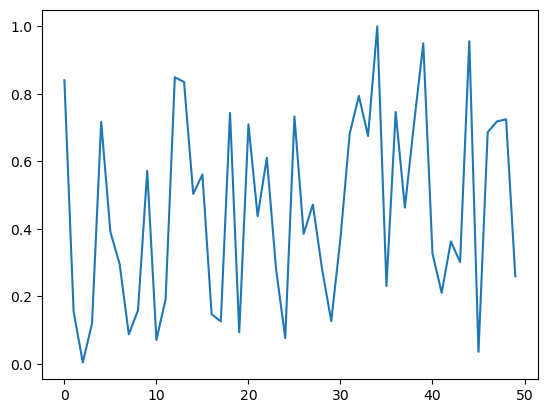

In [47]:
plt.plot([rand() for _ in range(50)]);

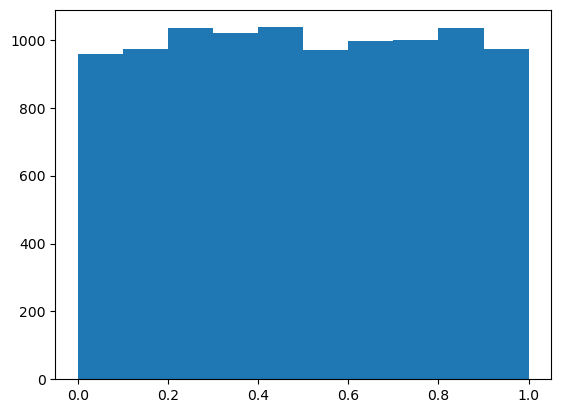

In [48]:
plt.hist([rand() for _ in range(10000)]);

In [49]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

2.07 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [50]:
%timeit -n 10 torch.randn(784,10)

The slowest run took 4.81 times longer than the fastest. This could mean that an intermediate result is being cached.
44 µs ± 33.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Matrix Multiplication

- Set manual seed
- Initialize weights for shape 784 x 10
- Initialize bias of zeros of shape 10

In [51]:
torch.manual_seed(4)

In [52]:
w = torch.randn(784, 10)
w.shape

torch.Size([784, 10])

In [53]:
b = torch.zeros(10)
b

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

- Create Matrix 1 consisting of the x validation set 
- Create Matrix 2 consisting of the weights

In [54]:
m1 = x_train[:5]

In [55]:
m2 = w

In [56]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

- Deconstruction the shape of each to 2 variables each, one for rows and one for columns

In [57]:
ar, ac = m1.shape
br, bc = m2.shape
(ar, ac), (br, bc)

((5, 784), (784, 10))

- Create a tensor of zeros, `t1`, with the dimensions Matrix 1 rows, Matrix 2 columns

In [58]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

- Create a loop that will get the dot product of Matrix 1 and Matrix 2 and store the results in `t1`

In [59]:
for i in range(ar):
    for j in range(bc):
        for k in range(ac):
            t1[i,j] += m1[i,k] * m2[k,j]

In [60]:
t1.shape

torch.Size([5, 10])

- Turn the loop into a callable function that takes 2 inputs representing the matrices

In [61]:
def matrix_mult(m1, m2):
    ar, ac = m1.shape
    br, bc = m2.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += m1[i,k] * m2[k,j]
    return c

- Time the Matrix multiplication loop

In [62]:
%time _ = matrix_mult(m1,m2)

CPU times: user 323 ms, sys: 0 ns, total: 323 ms
Wall time: 322 ms


### Numba

- import njit from numba

In [63]:
from numba import njit

- create a function that multiplies all the elements in 2 matrices and returns the sum, recreating the multiplication operation from the `matrix_mult` function

In [64]:
@njit
def dot(a, b):
    total = 0.
    for i in range(len(a)): 
        total += a[i] * b[i]
    return total

- Try with and without njit using numpy arrays

In [65]:
from numpy import array

dot(array([2.,4,5,6]), array([5.,4,6,8]))- Time both types of operations

In [66]:
dot(array([2.,4,5,6]), array([5.,4,6,8]))

104.0

In [67]:
%time dot(array([2.,4,5,6]), array([5.,4,6,8]))

CPU times: user 19 µs, sys: 1 µs, total: 20 µs
Wall time: 22.4 µs


104.0

In [68]:
%time dot(array([2.,4,5,6]), array([5.,4,6,8]))

CPU times: user 19 µs, sys: 2 µs, total: 21 µs
Wall time: 22.9 µs


104.0

- update `matrix_mult` to use the `dot` created above(using njit)

In [69]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [70]:
def matmul(m1, m2):
    ar, ac = m1.shape
    br, bc = m2.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):       #5
        for j in range(bc):   #784
            c[i,j] = dot(m1[i,:], m2[:,j])
    return c

- assign `m1` and `m2` as variables as numpy arrays 

In [71]:
m1a, m2a = m1.numpy(), m2.numpy()

- Use `test_close` on `t1` and `matmul`, imported from fastcore

In [72]:
from fastcore.test import *

In [73]:
test_close(t1, matmul(m1a, m2a))

- Time matmul

In [74]:
%timeit -n 50 matmul(m1a,m2a)

190 µs ± 15.2 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


### Elementwise Ops

- Create 2 Rank 1 tensors

In [75]:
a = tensor([1.,200,30,4,500,6])
b = tensor([10.,22,44,55,66,33])
a, b, len(a) == len(b)

(tensor([  1., 200.,  30.,   4., 500.,   6.]),
 tensor([10., 22., 44., 55., 66., 33.]),
 True)

- Add them

In [76]:
a + b

tensor([ 11., 222.,  74.,  59., 566.,  39.])

- Compare them > or < for boolean values

In [77]:
a > b

tensor([False,  True, False, False,  True, False])

- Get a percentage of true/false values

In [78]:
(a > b).float().mean()

tensor(0.3333)

- Create a new rank 2 tensor

In [79]:
m = tensor([[1.,2,3], [4,5,6], [7,8,9]])
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there (which is what I did for the above equation). Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and you should find the source there, including the equations to copy and paste. This is the source LaTeX that I pasted to render the equation above:

```latex
$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$
```

- Recreate the operation above on the `m` tensor created earlier

In [80]:
sf = (m*m).sum()
sf

tensor(285.)

In [81]:
sf.sqrt()

tensor(16.8819)

- Check the different ways to index select the rows and columns of `m`

In [82]:
m[2], m[2, :]

(tensor([7., 8., 9.]), tensor([7., 8., 9.]))

In [83]:
m[:, 2], m[:, 2]

(tensor([3., 6., 9.]), tensor([3., 6., 9.]))

- Update the matrix multiplication function to use elementwise operations instead of the `dot` function

In [84]:
def matmul(m1, m2):
    ar, ac = m1.shape
    br, bc = m2.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):       #5
        for j in range(bc):   #784
            c[i,j] = (m1[i,:] * m2[:,j]).sum()
    return c

- Check that we're getting the same result using `test_close`

In [85]:
test_close(t1, matmul(m1,m2))

- Use timeit to on 50 iterations to try the new function on `m1` and `m2`

In [87]:
%timeit -n 50 _=matmul(m1,m2)

483 µs ± 14 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


- Redefine `matmul` using `torch.dot` for the dot product and test its time

### Broadcasting

In [88]:
a

tensor([  1., 200.,  30.,   4., 500.,   6.])

- Use broadcasting to check *>0* with a scalar

- Normalize the dataset by subtracting the mean from the entire dataset and dividing by the standard deviation

- Add 1 using broadcasting to `a`

- Multiply rank-2 matrix by a scalar